In [3]:
import razor.flow as rf
from razor import api

import logging
import time
import typing as typ
import pandas as pd
import os

from razor.api.core import BlockScope
from razor.api import blocks

from razor.project.blocks.socket1 import STDIn
from razor.project.blocks.socket1 import STDOut


In [4]:
def project_space_path(path):
    ps = api.datasources('Project Space')
    return os.path.join(ps.abspath(), path)



In [6]:
@rf.block(executor=rf.FunctionExecutor)
class STDIn:    
    
    filename: str
    out_ds: rf.Output[typ.Any]
#     out_ds: rf.Output[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        df = pd.read_parquet(project_space_path(self.filename))

        print(df.shape)
        self.out_ds.put(df)


@rf.block(executor=rf.FunctionExecutor)
class STDOut:    
    
    in_ds: typ.Any
    out_filename: str

    def run(self):
        print(self.in_ds.shape)
        self.in_ds.to_parquet(project_space_path(self.out_filename), index=False)
            
        

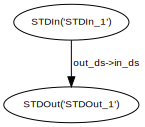

In [7]:
config = {'cores': 1, 'ram': 4096}


size = '10MB'
ip_filename = project_space_path("sdk_testbench/input_data/dummy_"+size+"_df.parquet")
op_filename = project_space_path("sdk_testbench/output_data/tc_01.parquet")

std_in = STDIn(filename=ip_filename)
# std_in.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])
# std_in.out_ds = rf.Output.set(transport=rf.KafkaTransport)

std_out = STDOut(in_ds=std_in.out_ds, out_filename=op_filename)
# std_out.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])

pipeline = rf.Pipeline(name='function_exec_memory_transport', targets=[std_out])
pipeline

In [8]:
pipeline.execute()

Process Pipeline Manager('test_pipeline'):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/razor/flow/pipeline.py", line 538, in _execute
    log_addr, log_level, None, this_run_params
  File "/usr/local/lib/python3.7/dist-packages/razor/flow/executors.py", line 462, in execute
    return self._execute(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/razor/flow/executors.py", line 435, in _execute
    self.logger = SocketLogger(f'{__name__}:{self.name}', log_addr, log_level)
  File "/usr/local/lib/python3.7/dist-packages/razor/flow/logging.py", line 24, in __init__
    logging.Logger.__init__(self, name=name, level=level)
  File "/usr/lib/python3.7/logging/__init__.py", line 1342, in __init__
    self.level = _checkLevel(level)


<Process(Pipeline Manager('test_pipeline'), stopped[1])>

In [12]:
pipeline.execute()

<Process(Pipeline Manager('test_pipeline'), stopped)>

In [7]:
import razor
razor.api.pipelines.save(pipeline)

RuntimeError: ('Failed to save pipeline! \n', 'Oops! Something went wrong. Please try again or contact support if the problem persists.')